In [1]:
# Imports

import numpy as np

from estimators.volt_funcs import Volterra
from estimators.volt_lasso_funcs import VolterraLasso
from estimators.ngrc_funcs import NGRC
from estimators.sindy_funcs import SINDyPolynomialSTLSQ
from estimators.polykernel_funcs import PolynomialKernel

from datagen.data_generate import rk45 
from utils.normalisation import normalise_arrays
from utils.plotting import plot_data, plot_data_distributions
from utils.errors import calculate_mse

In [2]:
# Prepare Lorenz datatsets

# Create the Lorenz dataset
def lorenz(t, Z, args):
    u, v, w = Z
    sig, beta, rho = args
    
    up = -sig*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    
    return np.array([up, vp, wp])

lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)

h = 0.005
t_span = (0, 40)
slicing = int(h/h)

t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)
t_eval = t_eval[::slicing]
data = data[::slicing]

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 5000 
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]

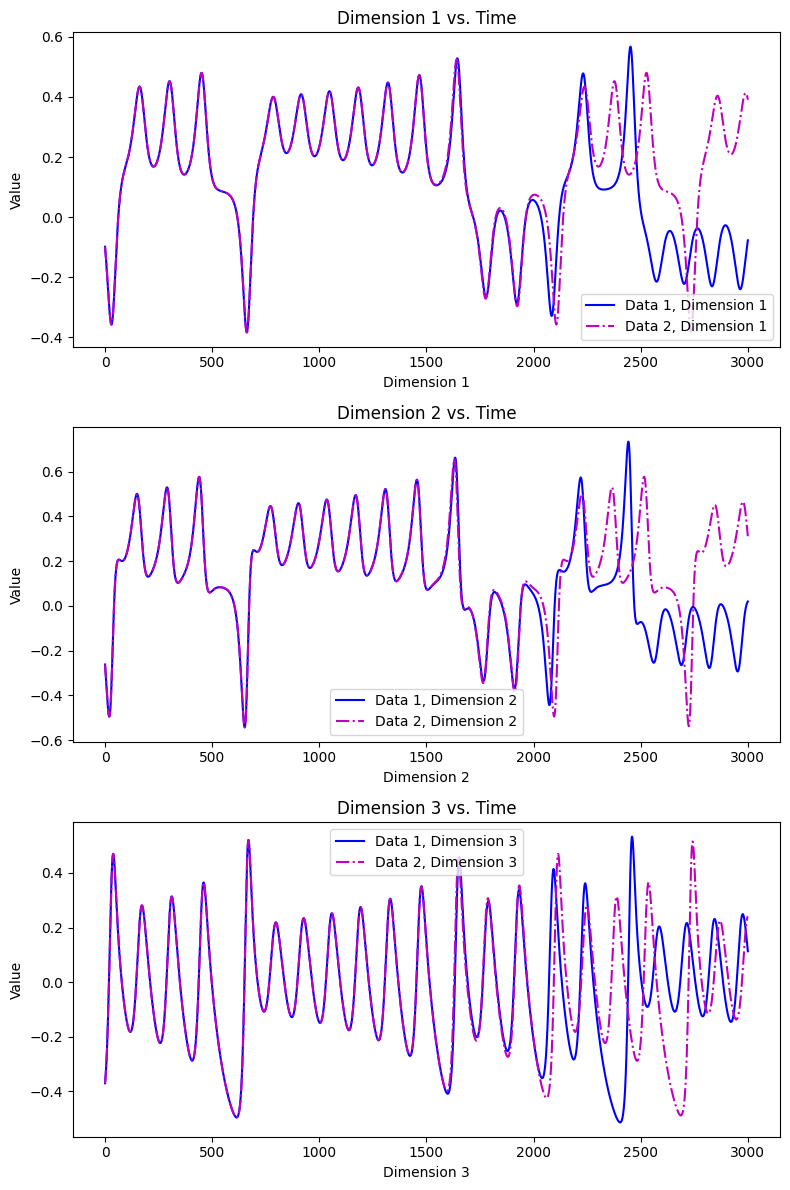

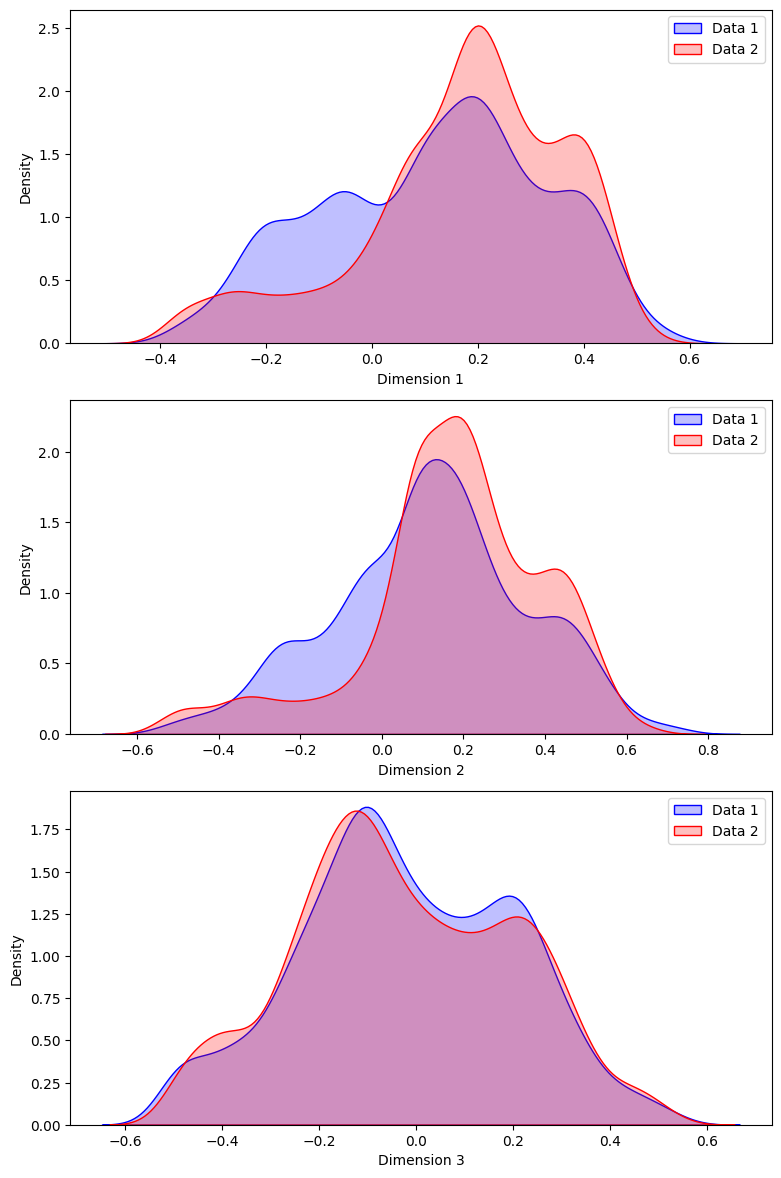

In [3]:
# Volterra with L2 least squares regression

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.8, 0.2, 1e-10, 1000

# Run Volterra as a class
volt = Volterra(ld_coef, tau_coef, reg, washout)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_volt = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

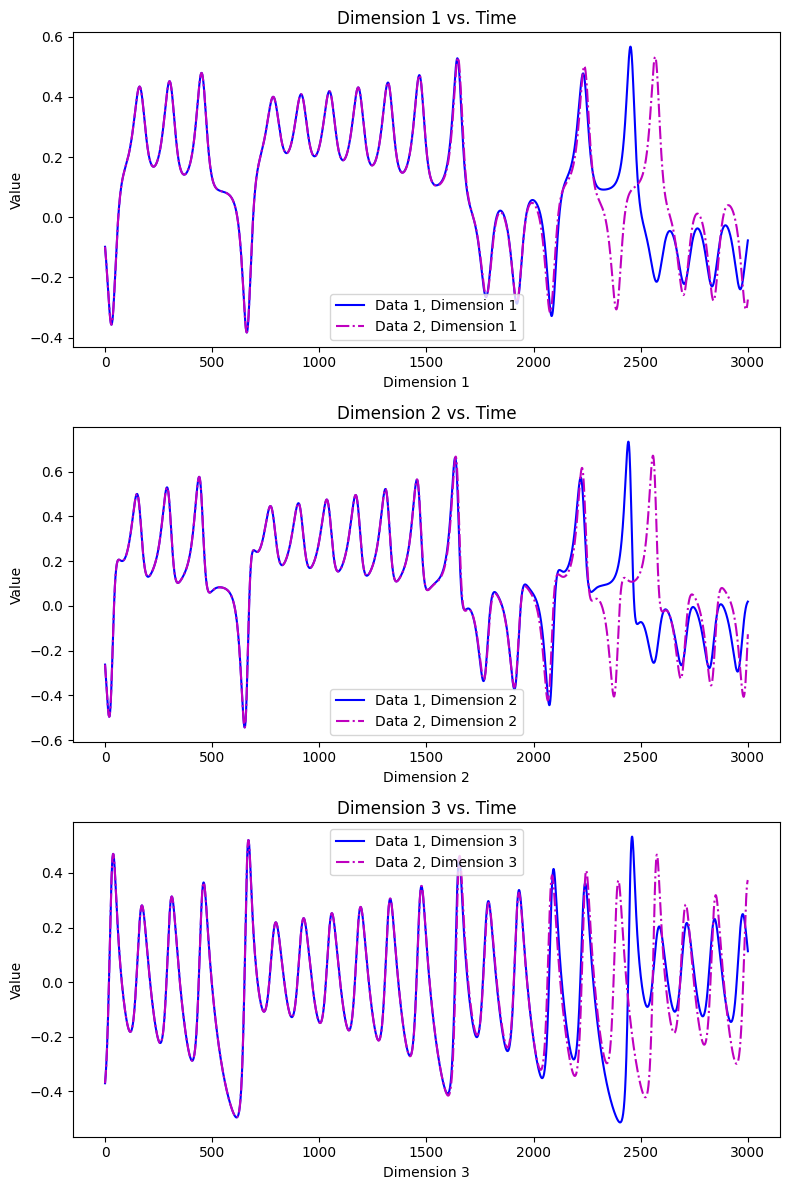

In [4]:
# Volterra with L2 least squares regression using pinv 

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.8, 0.2, 1e-10, 1000

# Run Volterra as a class
volt = Volterra(ld_coef, tau_coef, reg, washout, pinv=True)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_volt_pinv = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])

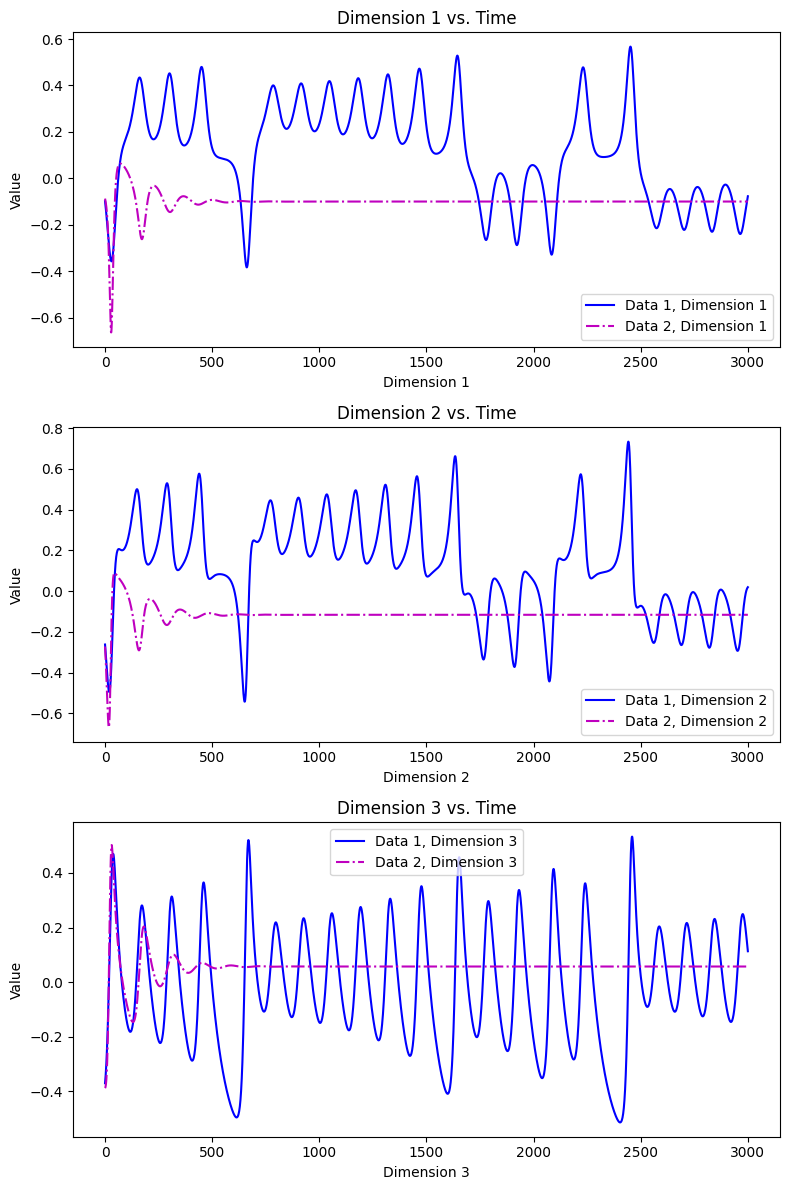

In [5]:
# Volterra with L2 least squares regression using pinv and only the last 28 features of the Gram matrix

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.8, 0.2, 1e-10, 1000

# Run Volterra as a class
volt = Volterra(ld_coef, tau_coef, reg, washout, nfeatures=28, pinv=True)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_volt_pinv_28 = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])

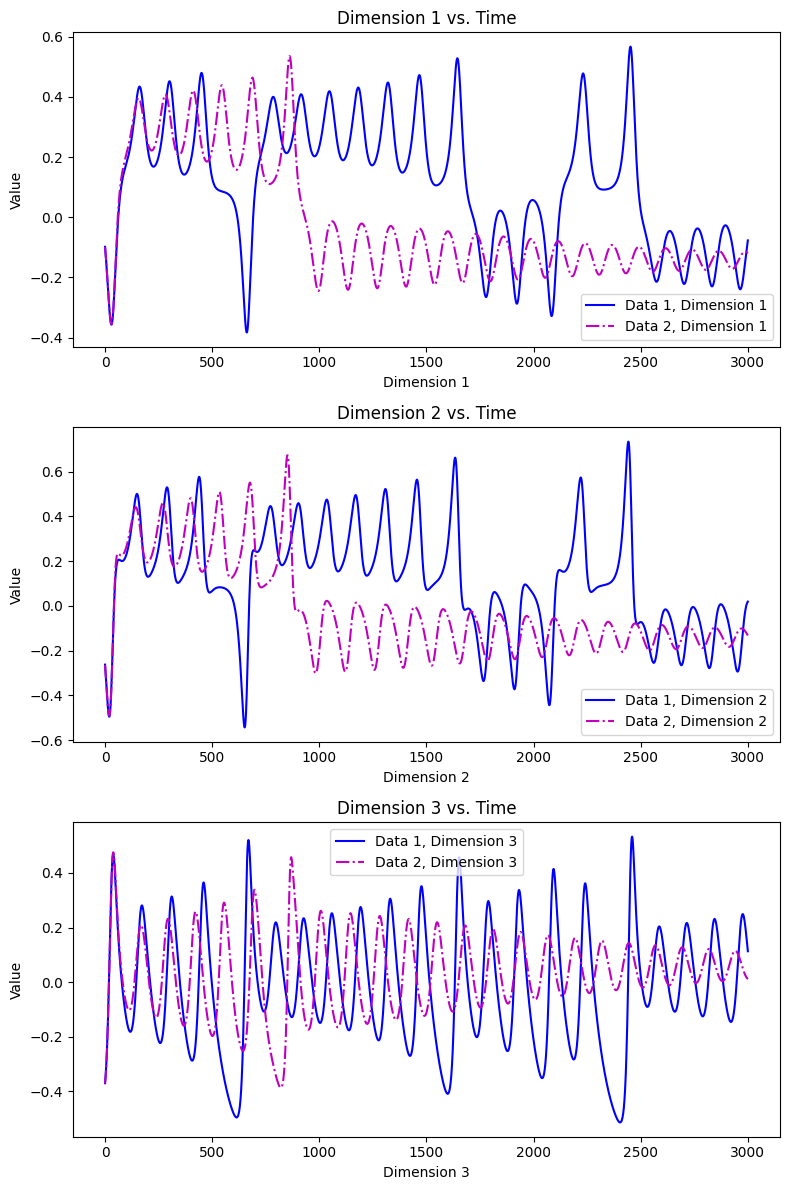

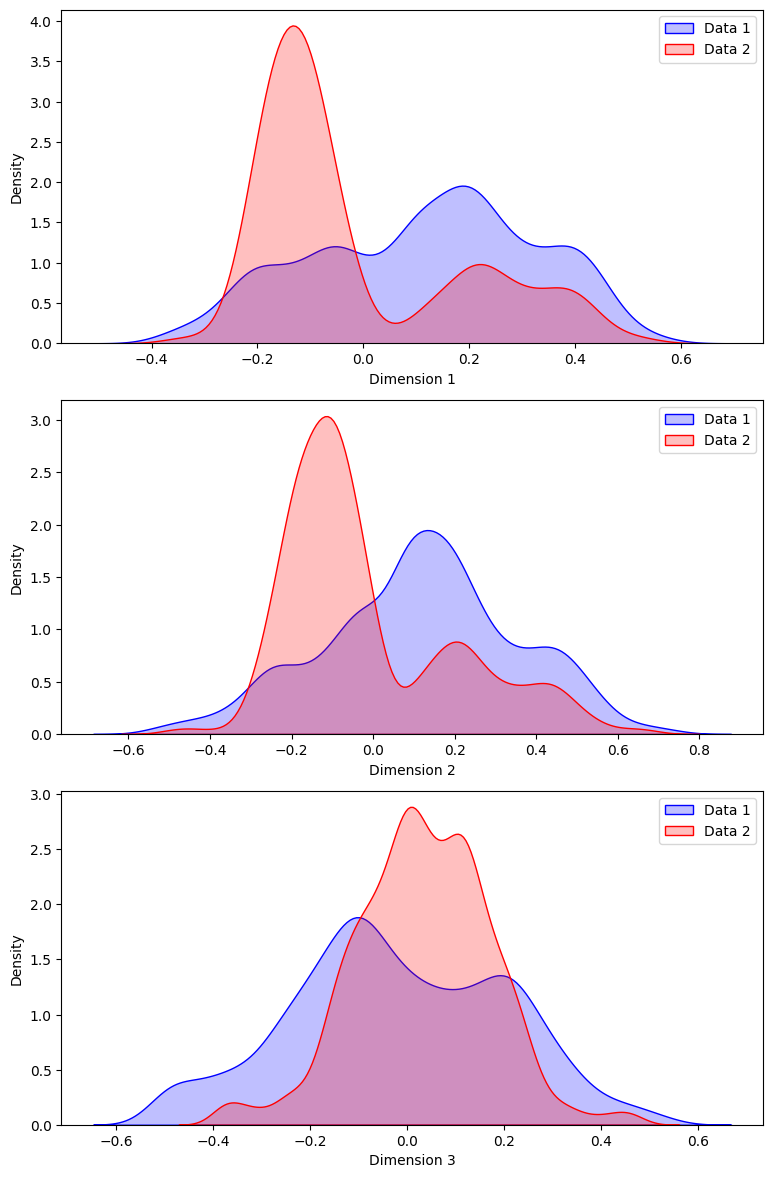

In [6]:
# Volterra using Lasso without controlling the number of features

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.99, 0.44, 1e-15, 1000

volt = VolterraLasso(ld_coef, tau_coef, reg, washout)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

mse_volt_lasso = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

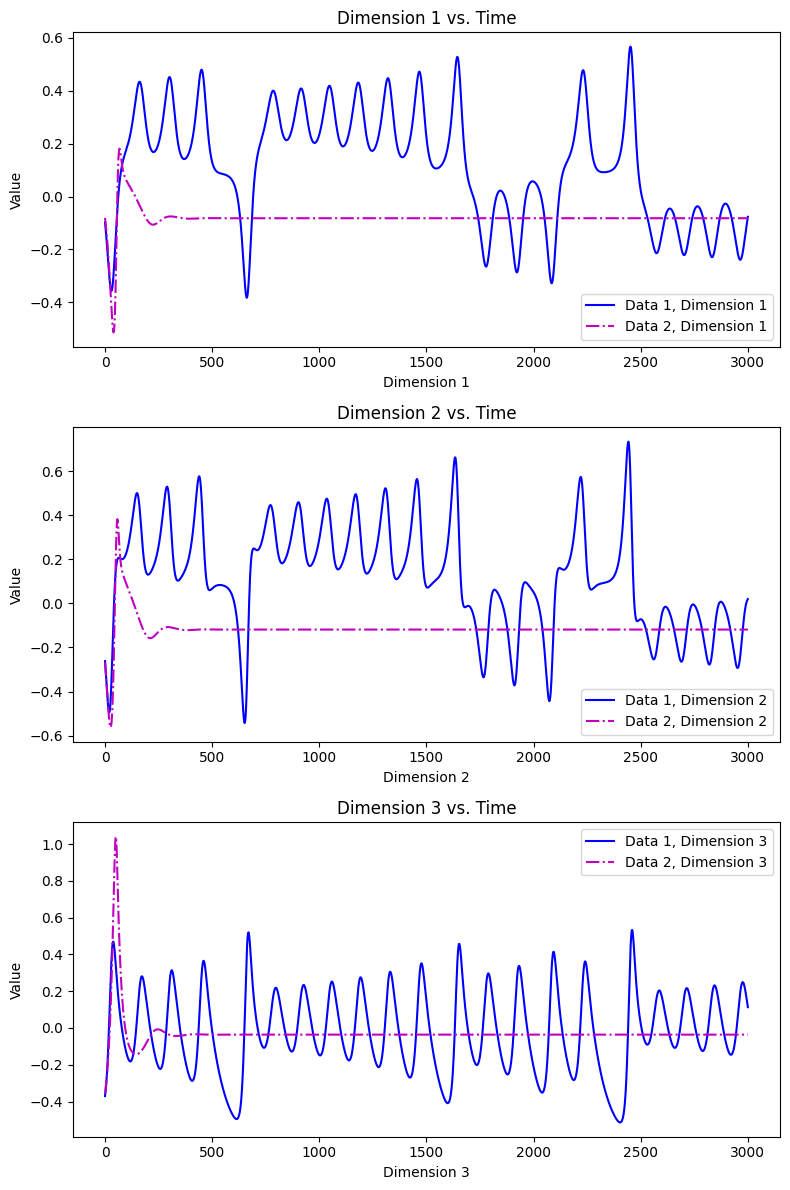

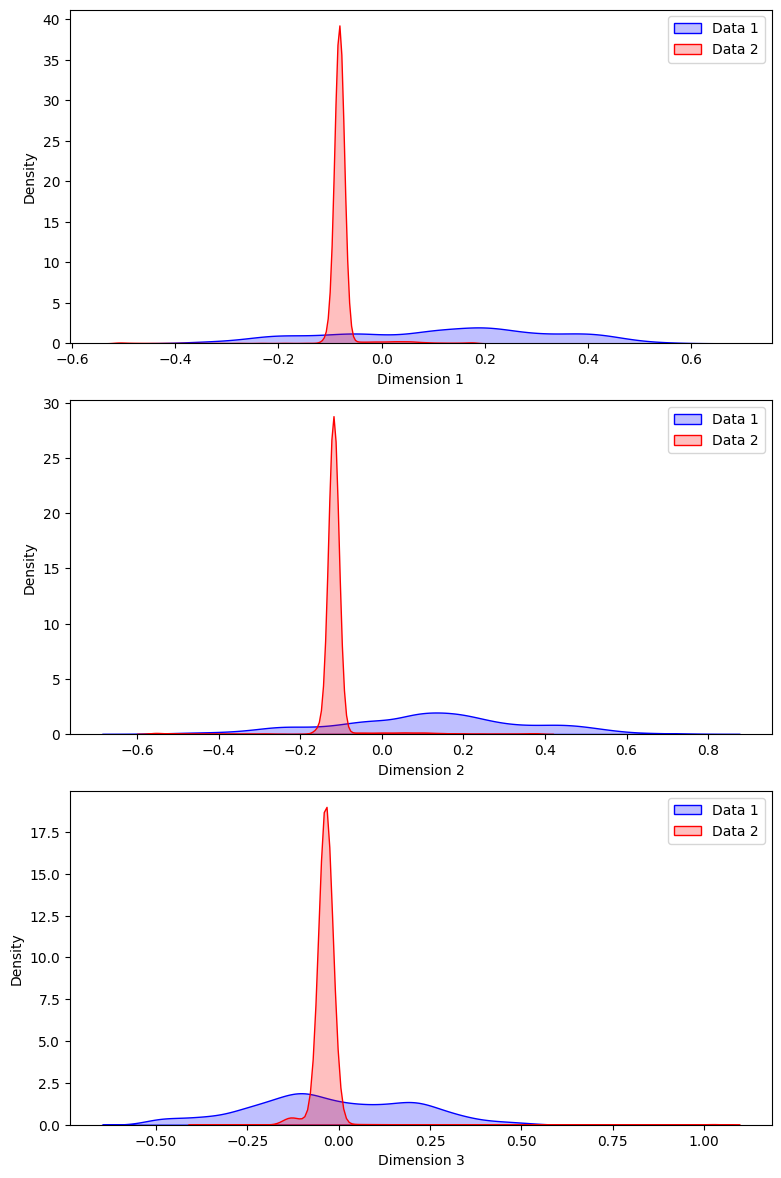

In [7]:
# Volterra using Lasso with controlling the number of features 

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, nfeatures, washout = 0.99, 0.44, np.logspace(-4, 0, 50), 28, 1000

volt = VolterraLasso(ld_coef, tau_coef, reg, washout, nfeatures, max_iter=1500, tol=1e-2)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

mse_volt_lasso_controlled = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

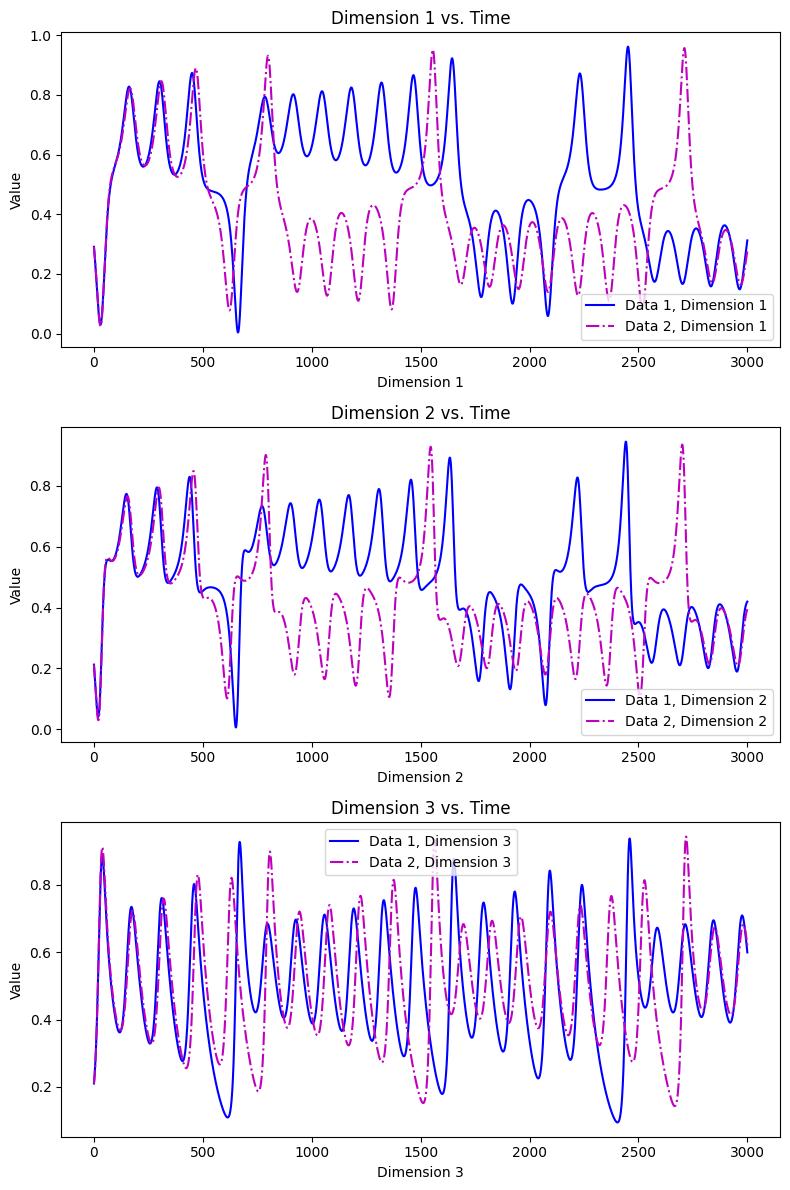

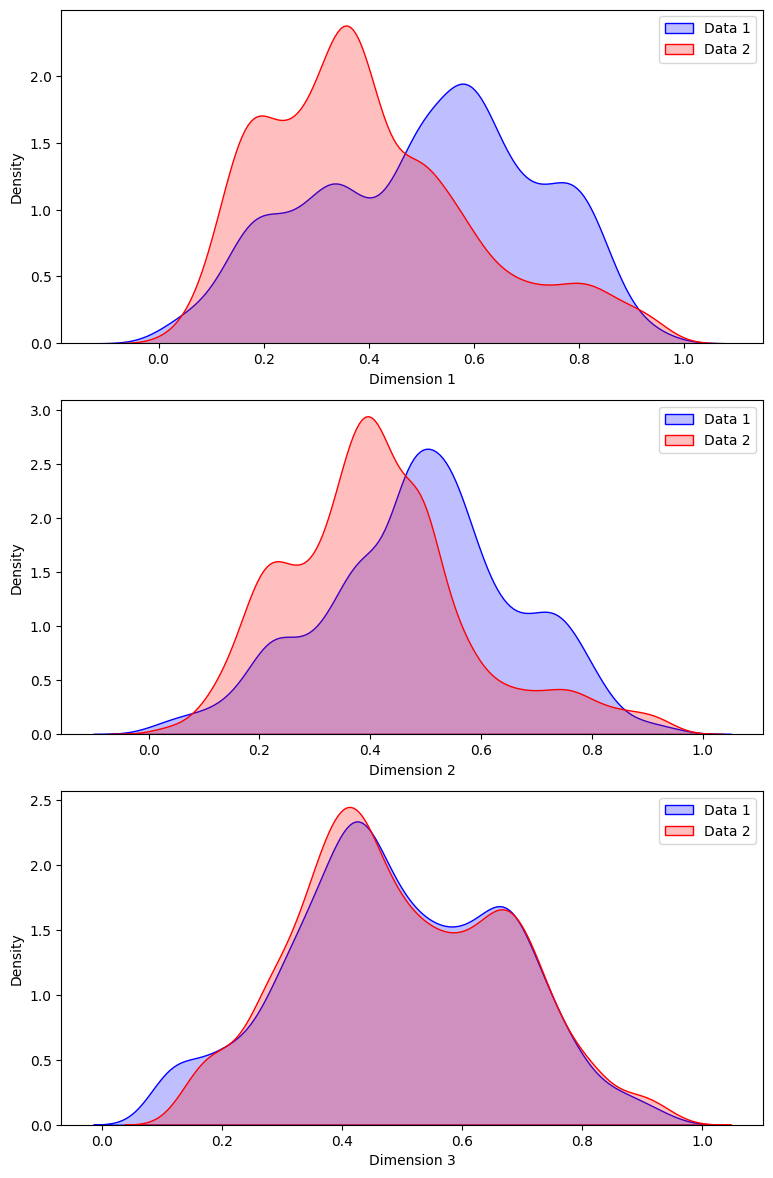

In [8]:
# NGRC defaults with pseudo inverse

# Normalise the arrays for NGRC
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="MinMax")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for NGRC
ndelay, deg, reg, washout = 2, 2, 0.1, 1000 # provided by Gauthier was 2.5e-6, washout 2

# Run the new NGRC class
ngrc = NGRC(ndelay, deg, reg, washout)
output = ngrc.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_ngrc = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

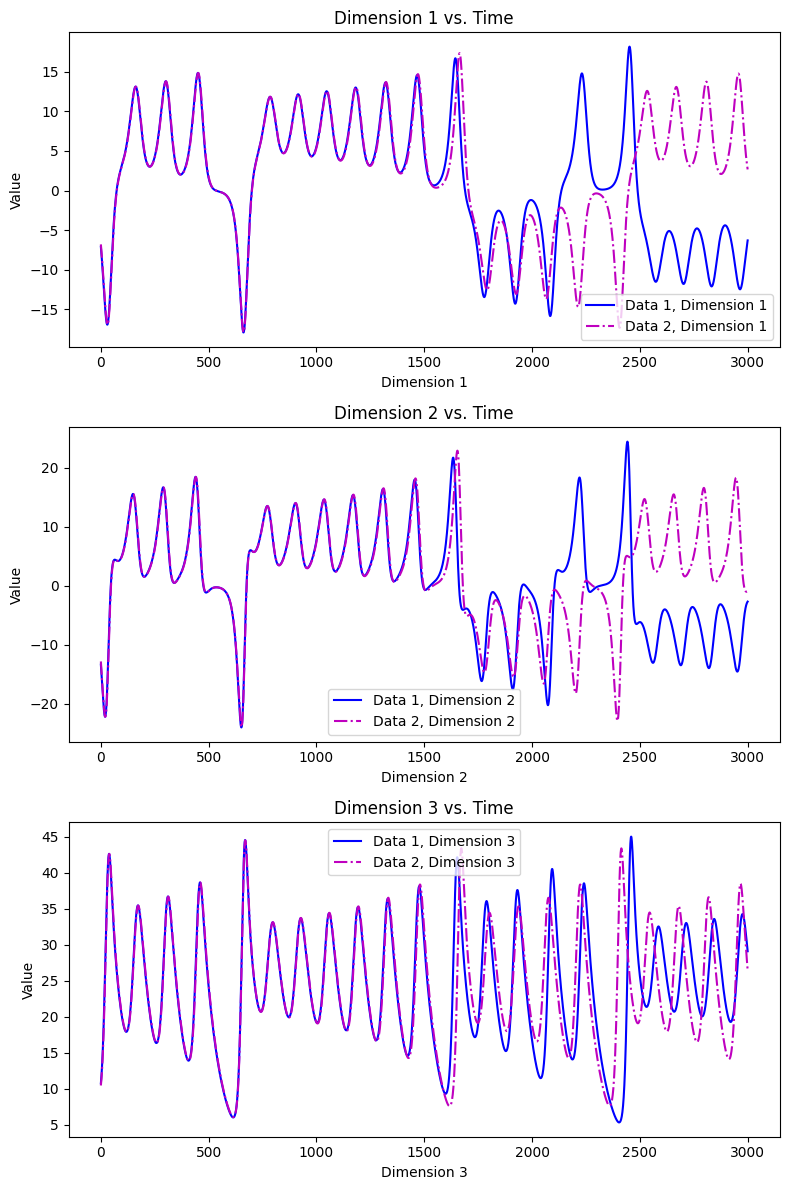

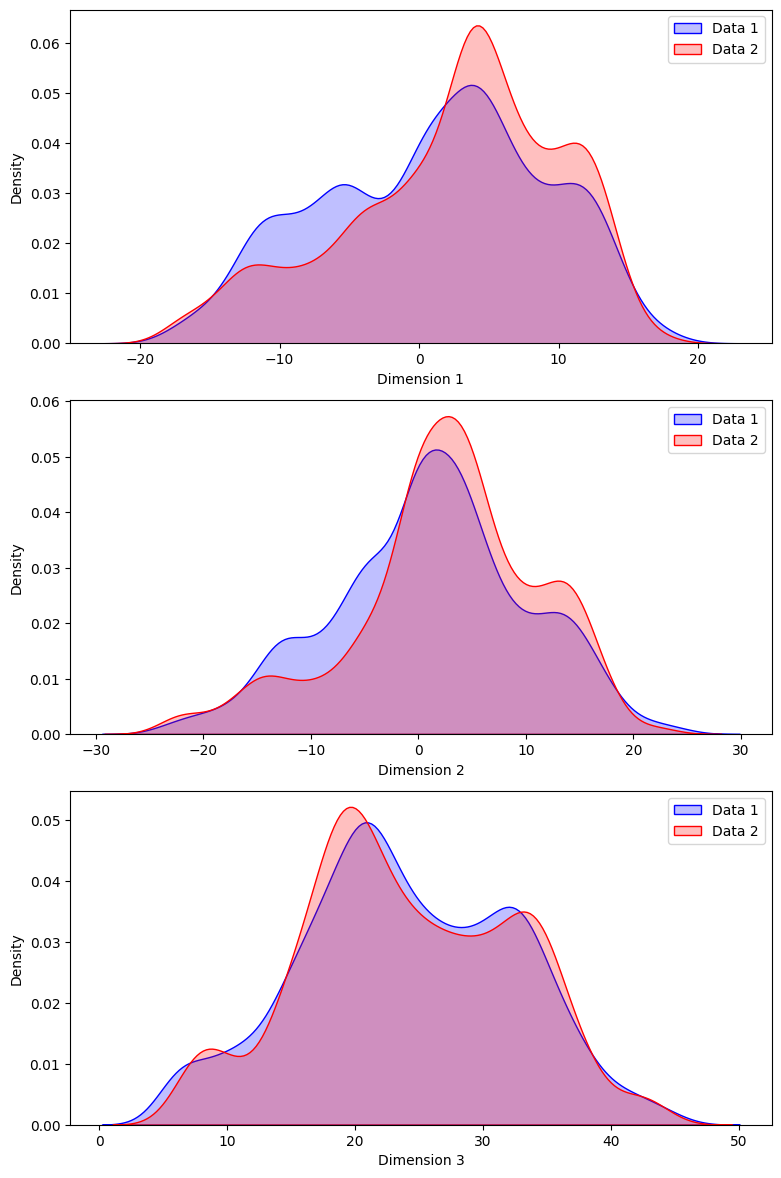

In [9]:
# SINDy

# Normalise the arrays for SINDy
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type=None)
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define the hyperparameters for SINDy
threshold, alpha, deg, washout = 0.1, 1e-15, 2, 1000

# Run the new SINDy functions
sindy = SINDyPolynomialSTLSQ(alpha, threshold, deg, h)
output = sindy.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_sindy = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

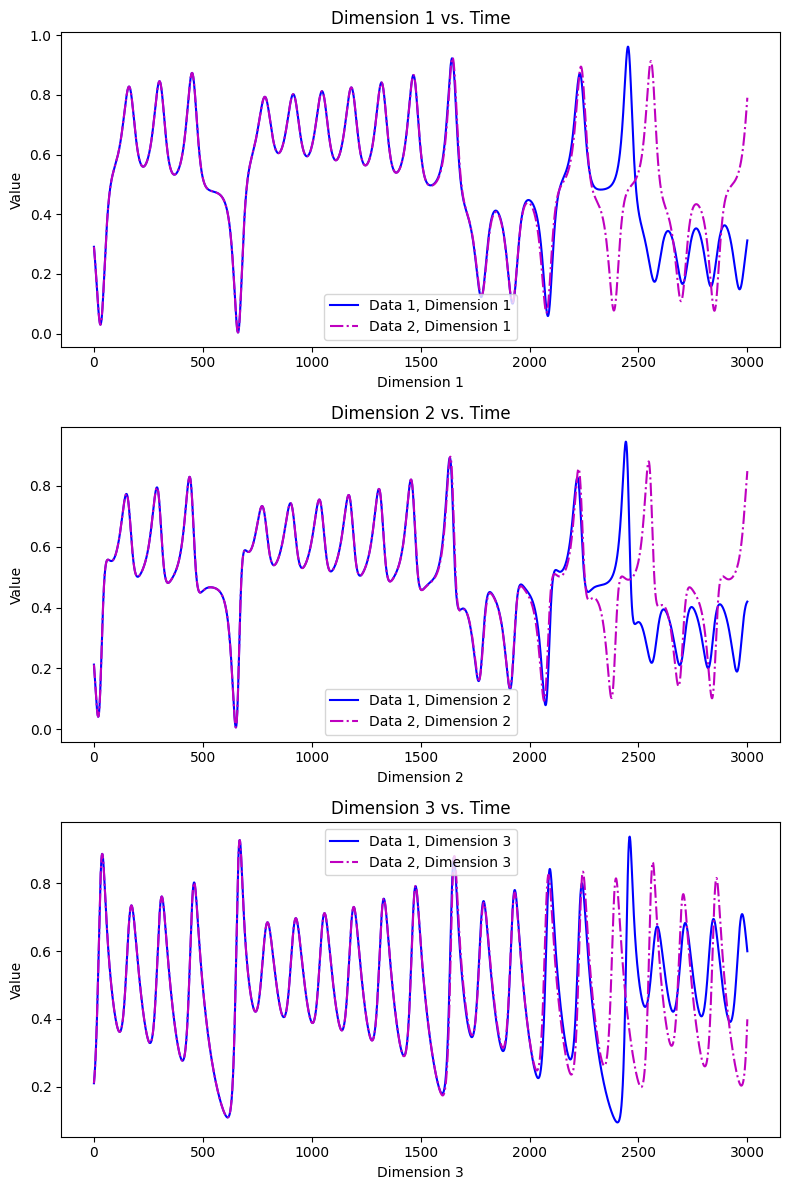

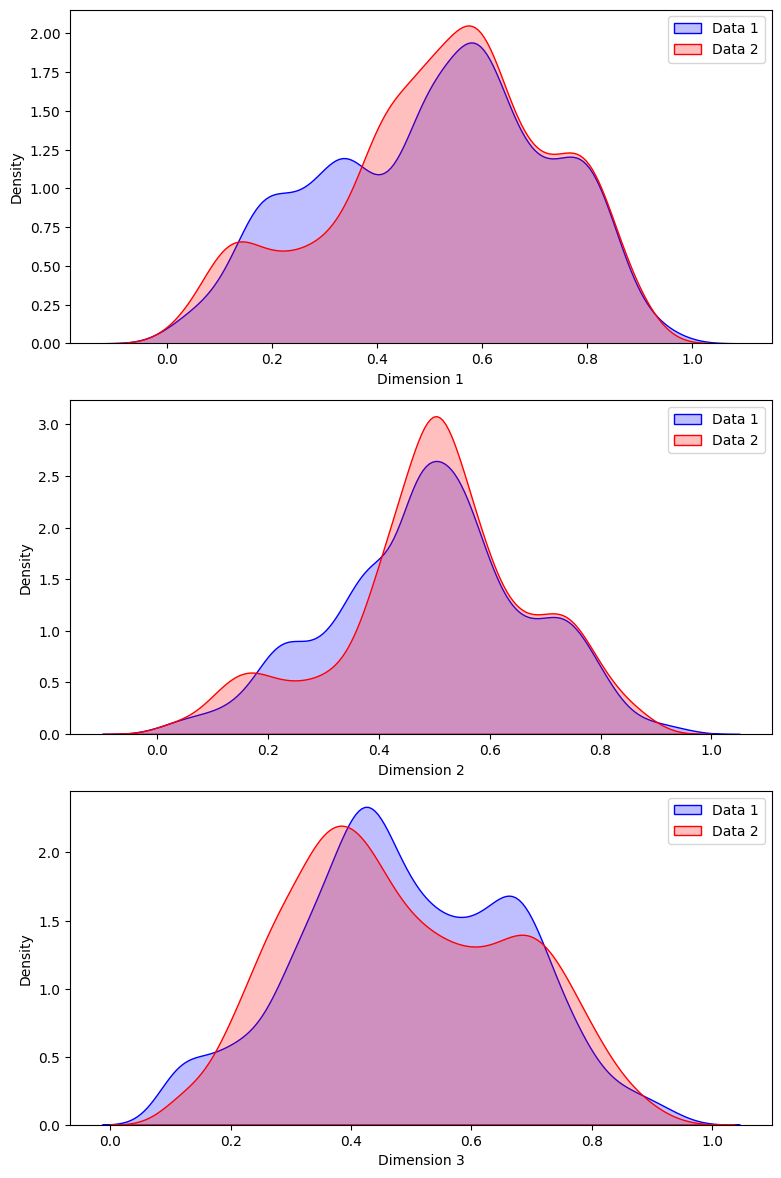

In [10]:
# Polynomial kernel 

# Normalise the arrays for Polykernel
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="MinMax")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define hyperparameters for Poly Kernel
deg, ndelays, reg, washout = 2, 7, 1e-7, 1000

# Run the new polynomial functinos
polykernel = PolynomialKernel(deg, ndelays, reg, washout)
output = polykernel.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_poly = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

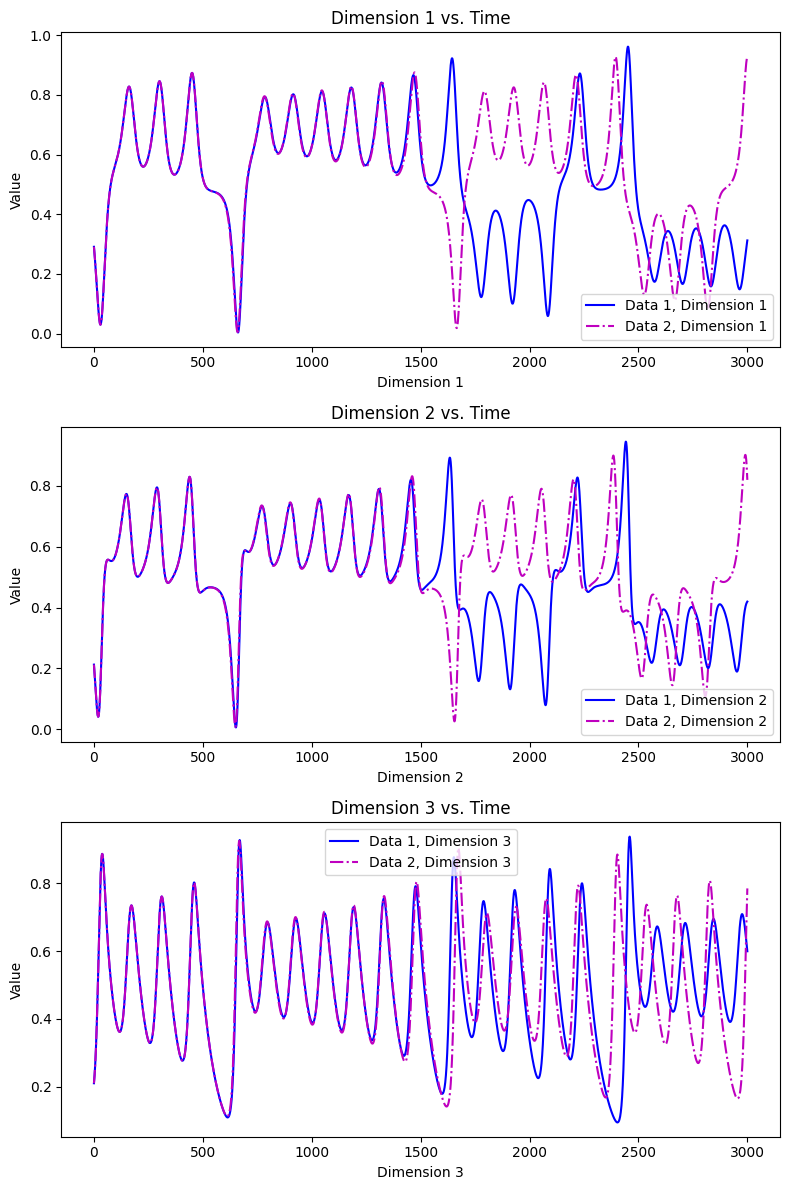

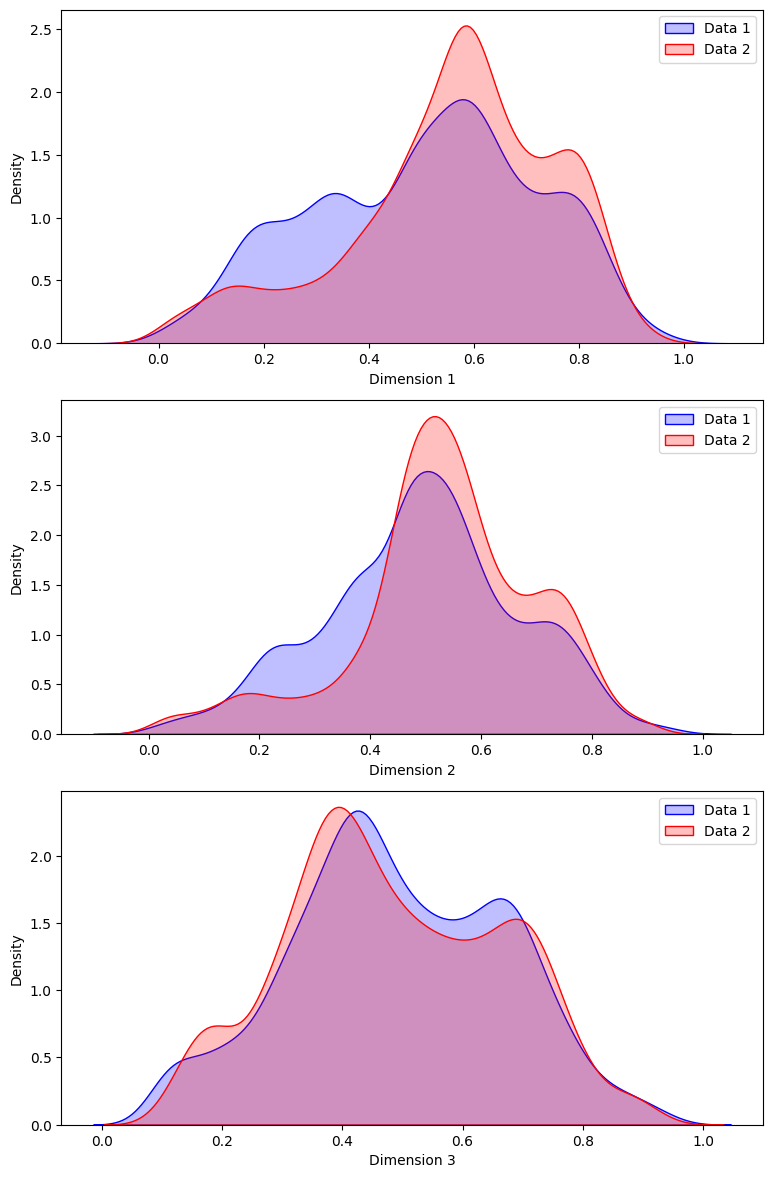

In [11]:
# Polynomial kernel with pseudo inverse

# Normalise the arrays for Polykernel
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="MinMax")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define hyperparameters for Poly Kernel
deg, ndelays, reg, washout = 2, 7, 1e-7, 1000

# Run the new polynomial functinos
polykernel = PolynomialKernel(deg, ndelays, reg, washout, pinv=True)
output = polykernel.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_poly_pinv = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

In [12]:
# Remove second and third dimensions from data

training_input_orig_x = training_input_orig[:, 0].reshape((-1, 1))
training_teacher_orig_x = training_teacher_orig[:, 0].reshape((-1, 1))
testing_input_orig_x = testing_input_orig[:, 0].reshape((-1, 1))
testing_teacher_orig_x = testing_teacher_orig[:, 0].reshape((-1, 1))

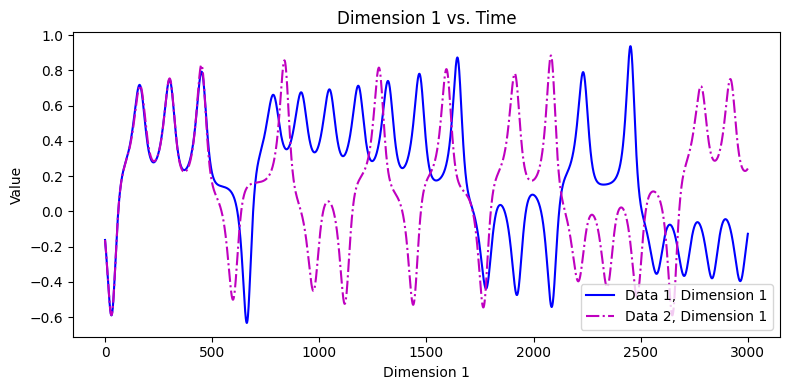

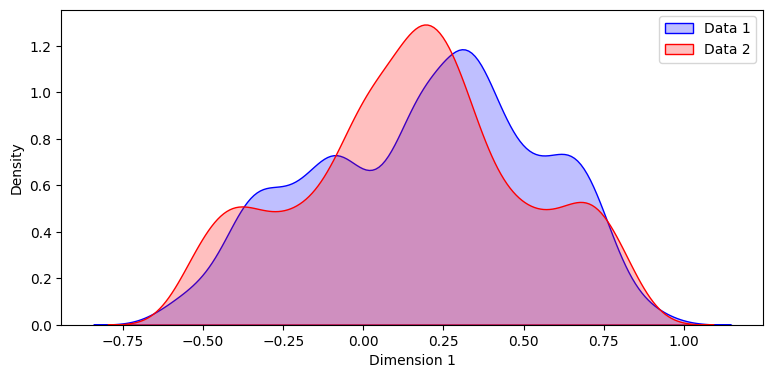

In [13]:
# Volterra observing only the first dimension

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig_x, training_teacher_orig_x, testing_input_orig_x, testing_teacher_orig_x], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.99, 0.73, 1e-8, 1000

# Run Volterra as a class
volt = Volterra(ld_coef, tau_coef, reg, washout)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_volt_x = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

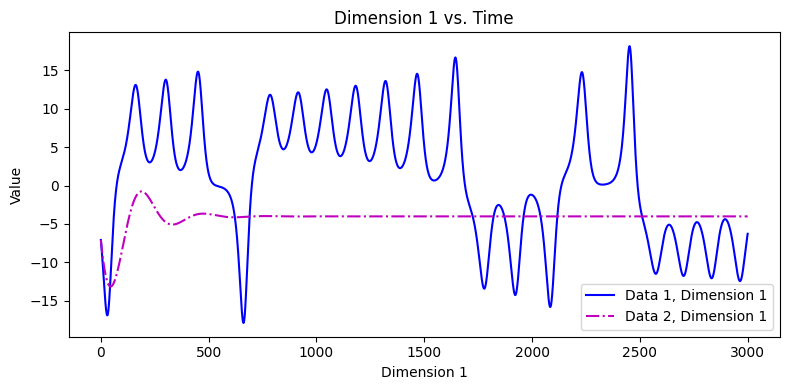

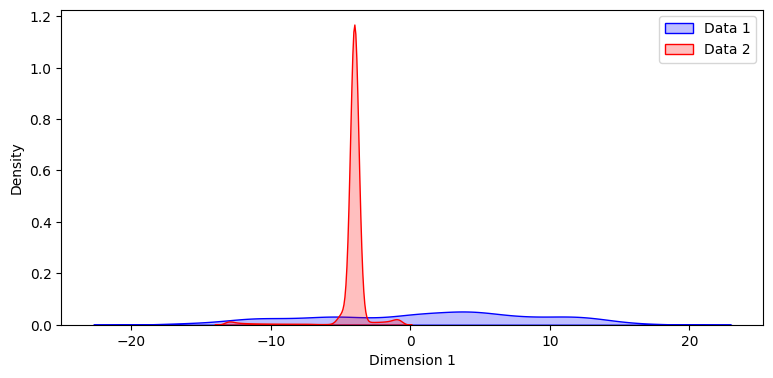

In [14]:
# NGRC observing only the first dimension

normalisation_output = normalise_arrays([training_input_orig_x, training_teacher_orig_x, testing_input_orig_x, testing_teacher_orig_x], norm_type=None)
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for NGRC
ndelay, deg, reg, washout = 2, 2, 1.0, 2

# Run the new NGRC class
ngrc = NGRC(ndelay, deg, reg, washout)
output = ngrc.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_ngrc_x = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

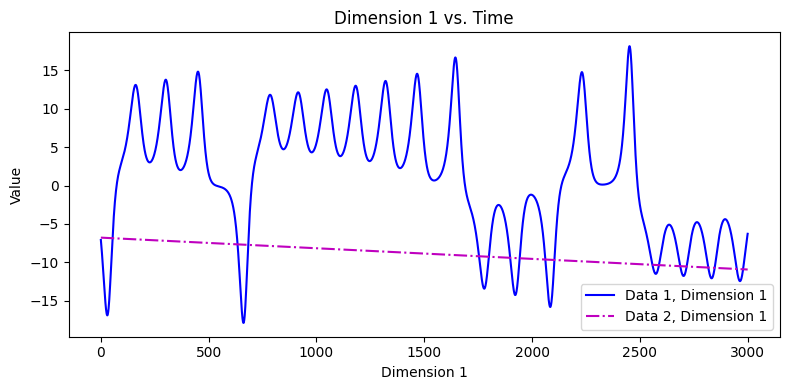

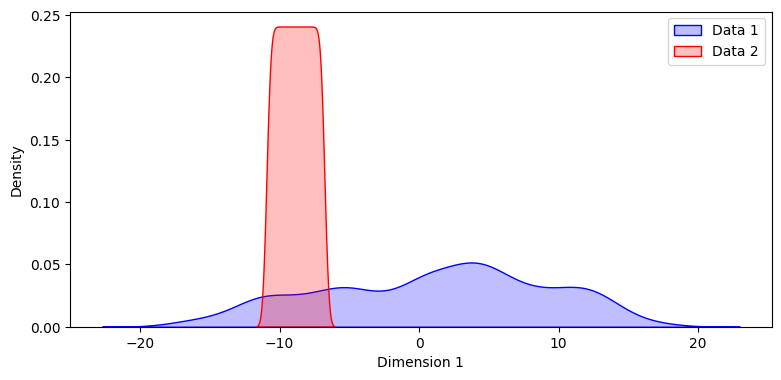

In [15]:
# SINDy observing only the first dimension

normalisation_output = normalise_arrays([training_input_orig_x, training_teacher_orig_x, testing_input_orig_x, testing_teacher_orig_x], norm_type=None)
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define the hyperparameters for SINDy
threshold, alpha, deg = 0.1, 1e-15, 2

# Run the new SINDy functions
sindy = SINDyPolynomialSTLSQ(alpha, threshold, deg, h)
output = sindy.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_sindy_x = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

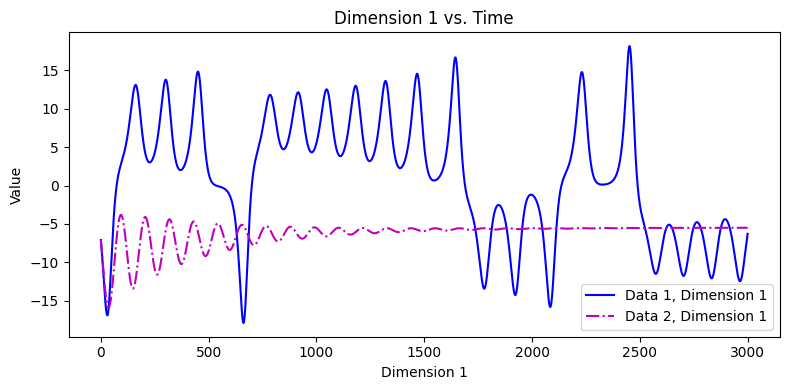

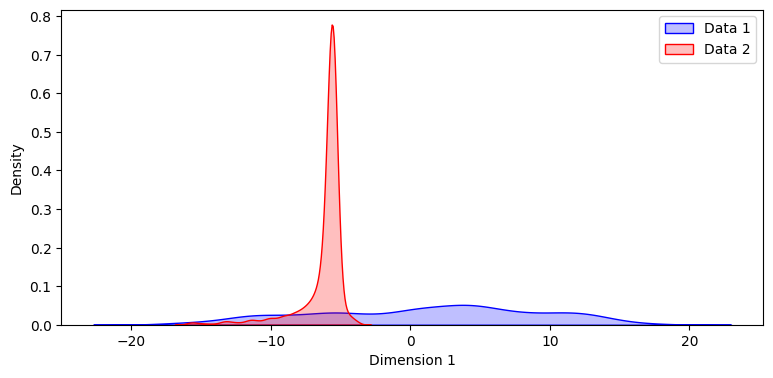

In [16]:
# Polynomial observing only the first dimension

# Normalise the arrays for Polykernel
normalisation_output = normalise_arrays([training_input_orig_x, training_teacher_orig_x, testing_input_orig_x, testing_teacher_orig_x], norm_type=None)
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define hyperparameters for Poly Kernel
deg, ndelays, reg, washout = 2, 6, 0.01, 1000

# Run the new polynomial functinos
polykernel = PolynomialKernel(deg, ndelays, reg, washout)
output = polykernel.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

# Compute the mse
mse_poly_x = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

In [17]:
# Cut data set to input x, y, and forecast z

training_input_orig_xy = data[0:ntrain, 0:2].reshape((-1, 2))
training_teacher_orig_z = data[0:ntrain, 2].reshape((-1, 1))
testing_input_orig_xy = data[0:ntrain, 0:2].reshape((-1, 2))
testing_teacher_orig_z = data[0:ntrain, 2].reshape((-1, 1))

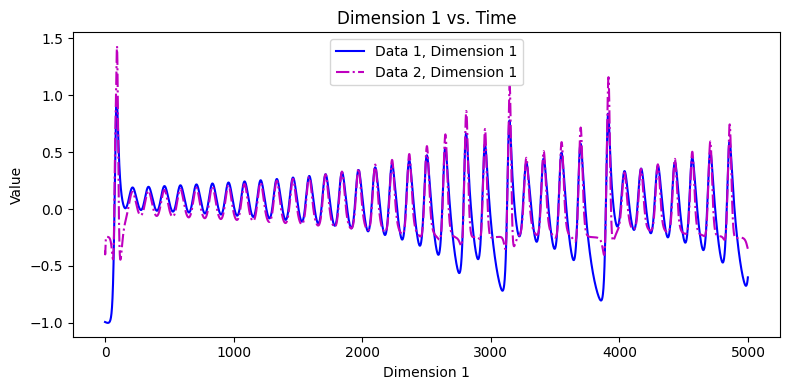

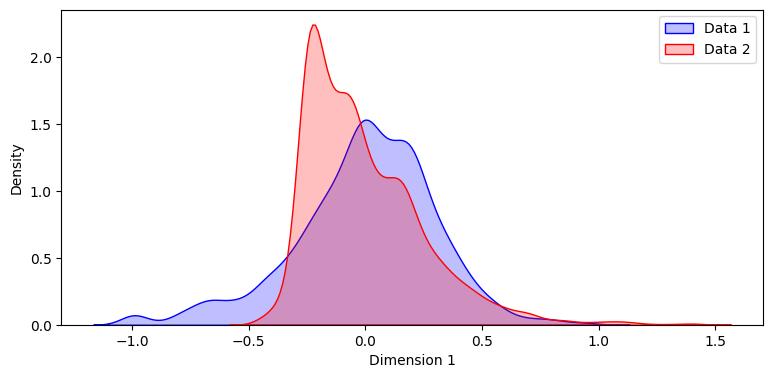

In [18]:
# Volterra input x, y, forecast z

normalisation_output = normalise_arrays([training_input_orig_xy, testing_input_orig_xy], norm_type="ScaleL2Shift")
train_input, test_input = normalisation_output[0]

normalisation_output = normalise_arrays([training_teacher_orig_z, testing_teacher_orig_z], norm_type="ScaleL2Shift")
train_teacher, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

# Define input hyperparameters for Volterra
ld_coef, tau_coef, reg, washout = 0.8, 0.5, 1e-2, 1000

# Run Volterra as a class
volt = Volterra(ld_coef, tau_coef, reg, washout)
output = volt.Train(train_input, train_teacher).Forecast(test_input)

# Compute the mse
mse_volt_xy_z = calculate_mse(test_teacher, output, shift, scale)

# Plot the forecast and actual
plot_data([test_teacher, output])
plot_data_distributions([test_teacher, output])

In [19]:
# Print MSEs

print("MSEs")
print("Volterra: ", mse_volt, " (CVed)")
print("Volterra with pinv: ", mse_volt_pinv, " (CVed)")
print("Volterra with pinv and 28 features: ", mse_volt_pinv_28, " (CVed)")
print("Volterra with Lasso: ", mse_volt_lasso)
print("Volterra with Lasso controlled nfeatures: ", mse_volt_lasso_controlled, " (CVed)")
print("NGRC: ", mse_ngrc, " (CVed)")
print("SINDy: ", mse_sindy, " (CVed)")
print("Polynomial Kernel: ", mse_poly, " (CVed)")
print("Polynomial Kernel: with pinv", mse_poly_pinv, " (CVed)")

print()

print("MSEs when using partial observations")
print("Volterra with first dimension: ", mse_volt_x, " (CVing)")
print("NGRC with first dimension: ", mse_ngrc_x, "(CVed)")
print("Polynomial kernel with first dimension: ", mse_poly_x, "(CVed)")
print("SINDy with first dimension: ", mse_sindy_x)

print()

print("MSEs when observing x, y, forecasating z")
print("Volterra with x, y, forecast z: ", mse_volt_xy_z)

MSEs
Volterra:  46.11958566858405  (CVed)
Volterra with pinv:  26.843773404648903  (CVed)
Volterra with pinv and 28 features:  122.41527882759398  (CVed)
Volterra with Lasso:  113.8273402595096
Volterra with Lasso controlled nfeatures:  116.03385870778695  (CVed)
NGRC:  115.6747898395732  (CVed)
SINDy:  62.45528888370892  (CVed)
Polynomial Kernel:  32.15246221948591  (CVed)
Polynomial Kernel: with pinv 68.89047362940671  (CVed)

MSEs when using partial observations
Volterra with first dimension:  126.40349636963919  (CVing)
NGRC with first dimension:  89.22611970861311 (CVed)
Polynomial kernel with first dimension:  121.5877376250146 (CVed)
SINDy with first dimension:  156.54685413545414

MSEs when observing x, y, forecasating z
Volterra with x, y, forecast z:  13.697245156822884
